> **이 코드는 Decision Tree를 이용해서 최적의 threshold를 구한다**

- 거리가 저장된 csv file을 사용
    * `pair_with_dist_Asian.csv` - 동양인(face train data)
    * `pair_with_dist_lfw.csv` - 서양인(lfw)
- k-fold 사용하지 않고 전체 데이터를 이용해서 구함
- gini 계수가 기준

In [1]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 동양인 데이터
- 같은 사람 3000 pairs, 다른 사람 3000 pairs

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/기업프로젝트-라젠/deepface/tests/pair_with_dist_Asian.csv')
df1

,file_x,file_y,decision,distance,distance_l2
0,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,11.1794,1.3843
1,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,7.3643,0.6335
2,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,8.3086,1.2123
3,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,12.0697,1.2579
4,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,Yes,11.8796,1.2326
...,...,...,...,...,...
5995,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,10.3889,1.2115
5996,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,3.4046,0.6786
5997,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,10.9161,1.0488
5998,/content/drive/My Drive/기업프로젝트-라젠/d...,/content/drive/My Drive/기업프로젝트-라젠/d...,No,10.8688,1.0539


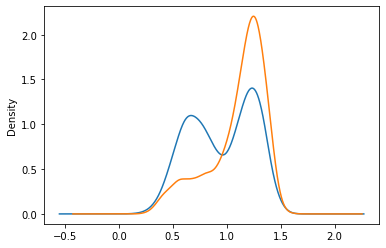

In [4]:
df1[df1.decision == "Yes"].distance_l2.plot.kde()
df1[df1.decision == "No"].distance_l2.plot.kde()

In [5]:
df1['distance_l2_scaled'] = -df1['distance_l2']

In [6]:
df1.describe()

,distance,distance_l2,distance_l2_scaled
count,6000.000000,6000.000000,6000.000000
mean,8.925200,1.024762,-1.024762
std,3.383794,0.292443,0.292443
min,1.010600,0.154200,-1.584400
25%,6.805025,0.780900,-1.261125
50%,9.796750,1.114450,-1.114450
75%,11.315675,1.261125,-0.780900
max,19.447200,1.584400,-0.154200


# threshold 정하기

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import graphviz
from sklearn.tree import export_graphviz

In [8]:
encoder = LabelEncoder()
encoder.fit(df1['decision'])
df1['y'] = encoder.transform(df1['decision']) # 1='Yes' / 0='No'

In [9]:
clf1 = DecisionTreeClassifier(max_depth=1)
X = np.array(df1['distance_l2']).reshape(-1, 1)
y = np.array(df1['y']).reshape(-1, 1)
clf1.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
clf1.score(X, y) # accuracy

0.6271666666666667

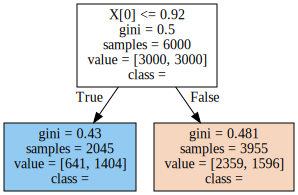

In [11]:
export_graphviz(clf1, out_file='clf1.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf1.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [12]:
threshold = clf1.tree_.threshold[0]
print('threshold: {}'.format(threshold))
df1["pred_euclidean_l2_from_dt"] = "No"
idx = df1[df1.distance_l2 <= threshold].index
df1.loc[idx, 'pred_euclidean_l2_from_dt'] = 'Yes'

threshold: 0.9203500151634216


In [13]:
cm = confusion_matrix(df1.decision.values, df1.pred_euclidean_l2_from_dt.values)
cm 

array([[2359,  641],
       [1596, 1404]])

In [14]:
tn, fp, fn, tp = cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  68.65525672371639 %
Recall:  46.800000000000004 %
F1 score  55.65906838453915 %
Accuracy:  62.71666666666667 %


---

# 2. lfw 데이터

In [15]:
df2 = pd.read_csv('/content/drive/MyDrive/기업프로젝트-라젠/deepface/tests/pair_with_dist_lfw.csv')
df2

,file_x,file_y,decision,distance_l2
0,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,0.6724
1,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,0.6943
2,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,0.8109
3,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,1.5055
4,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,Yes,1.2800
...,...,...,...,...
5995,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.3550
5996,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.4504
5997,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.5216
5998,/content/drive/My Drive/main_proj/라젠/deepfa...,/content/drive/My Drive/main_proj/라젠/deepfa...,No,1.1188


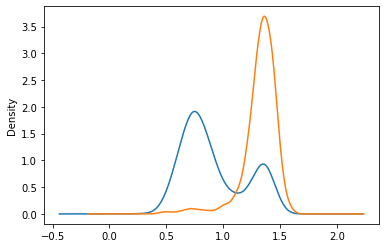

In [16]:
df2[df2.decision == "Yes"].distance_l2.plot.kde()
df2[df2.decision == "No"].distance_l2.plot.kde()

In [17]:
df2['distance_l2_scaled'] = -df2['distance_l2']

In [18]:
encoder = LabelEncoder()
encoder.fit(df2['decision'])
df2['y'] = encoder.transform(df2['decision']) # 1='Yes' / 0='No'

In [19]:
clf2 = DecisionTreeClassifier(max_depth=1)
X = np.array(df2['distance_l2']).reshape(-1, 1)
y = np.array(df2['y']).reshape(-1, 1)
clf2.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
clf2.score(X, y) # accuracy

0.8366666666666667

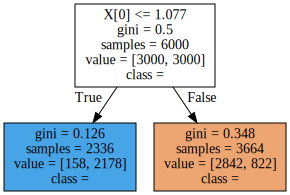

In [21]:
export_graphviz(clf2, out_file='clf2.dot', class_names=['불일치', '일치'], impurity=True, filled=True)
with open('clf2.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [22]:
threshold = clf2.tree_.threshold[0]
print('threshold: {}'.format(threshold))

threshold: 1.076550006866455


In [23]:
df2["pred_euclidean_l2_from_dt"] = "No"

idx = df2[df2.distance_l2 <= threshold].index
df2.loc[idx, 'pred_euclidean_l2_from_dt'] = 'Yes'

In [24]:
cm = confusion_matrix(df2.decision.values, df2.pred_euclidean_l2_from_dt.values)
cm 

array([[2842,  158],
       [ 822, 2178]])

→ false positive (불일치인데 일치로 판단한 경우) : 158 cases

In [25]:
tn, fp, fn, tp = cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  93.23630136986301 %
Recall:  72.6 %
F1 score  81.63418290854571 %
Accuracy:  83.66666666666667 %


# 논문에 있는 threshold 사용(lfw)

In [ ]:
# threshold = 1.2
threshold = -1.2

df2["pred_euclidean_l2_from_paper"] = "No"
idx = df2[df2.distance_l2 <= -threshold].index
df2.loc[idx, 'pred_euclidean_l2_from_paper'] = 'Yes'

In [ ]:
cm = confusion_matrix(df2.decision.values, df2.pred_euclidean_l2_from_paper.values)
cm 

array([[2640,  360],
       [ 694, 2306]])

→ false positive (불일치인데 일치로 판단한 경우) : 360 cases

In [ ]:
tn, fp, fn, tp = cm.ravel()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  86.49662415603902 %
Recall:  76.86666666666667 %
F1 score  81.39781150723616 %
Accuracy:  82.43333333333334 %
